# How to use the `nnde` package to solve an ordinary differential equation

## Introduction

This notebook will walk you through the process of solving an ordinary differential equation (ODE) using the `nnde` python package. The purpose of this notebook is to illustrate the use of the `nnde` package for solving a specific problem by identifying and performing each of the steps required to solve the problem.

This tutorial shows how to solve an ODE interactively using a Jupyter notebook. For more complicated equations, we suggest placing the various required Python functions in an equation definition file. This file can then be passed to `nnde` to define the equation to solve. To see an example of this method, examine the example script `simple_01_nnde.py`.

The `nnde` package contains modules for solving several types of differential equations:

* 1st-order ODE initial value problems (IVP)
* 1st-order partial differential equation (PDE) IVP
* 2nd-order PDE for the diffusion equation in 1, 2, and 3 spatial dimensions

## Notation and terminology

The internal structure of the `nnde` package requires that certain naming conventions are followed by the user when defining code to be used by the `nnde` package.

The symbol $G$ is used to representhe the differential equation itself, written in the standard form:

\begin{equation}
    G \left( x, Y, \frac {dY} {dx} \right) = 0
\end{equation}

where $x$ is the independent variable, and $Y(x)$ is the dependent variable. The purpose of the software is to determine $Y(x)$ given the form of $G$, and a set of training points.

Note that the character `Y` is used for the dependent variable, rather than the more traditional `y`. This was done to make it easier to visually identify uses of this variable in the code.

As an example, consider the ordinary differential equation:

\begin{equation}
    \frac {dY} {dx} = \cos (x) + 1
\end{equation}

Rewritten in standard form, this becomes:

\begin{equation}
    G \left( x, Y, \frac {dY} {dx} \right) = \frac {dY} {dx} - \cos (x) - 1 = 0
\end{equation}

## Solving an ordinary differential equation

### Define the differential equation

We start by defining the form of the differential equation we want to solve. For this tutorial, consider the following 1st-order ordinary differential equation:

\begin{equation}
    \frac {dY} {dx} + \left (x+\frac {1+3x^2} {1+x+x^3} \right ) Y =
    x^3 + 2x + x^2 \frac {1+3x^2} {1+x+x^3}
\end{equation}

The initial condition is:

\begin{equation}
    Y(0) = 1
\end{equation}

Rewritten in standard form, the equation becomes:

\begin{equation}
    G\left(x,Y,\frac {dY}{dx}\right) = \frac {dY} {dx} + \left (x+\frac {1+3x^2} {1+x+x^3} \right ) Y - x^3 - 2x - x^2 \frac {1+3x^2} {1+x+x^3} = 0
\end{equation}

The ordinary differential equation has the analytical solution:

\begin{equation}
    Y_a(x) = x^2 + \frac {e^{-x^2/2}} {1 + x +  x^3}
\end{equation}

and the analytical first derivative:

\begin{equation}
    \frac {dY_a} {dx} = 2x - \frac {e^{-x^2/2} (1+x+4x^2+x^4)} {(1+x+x^3)^2}
\end{equation}

Plots of the analytical solution and first derivative over the domain $[0,1]$ are shown below.

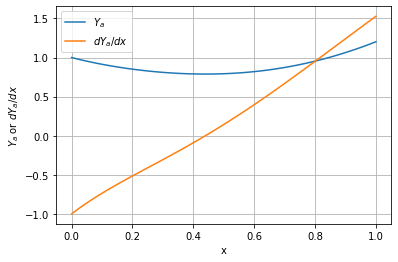

In [1]:
# Import required packages.
from math import exp
import numpy as np
import matplotlib.pyplot as plt

# Define a function for the analytical solution.
def Y_analytical(x):
    return x**2 + exp(-x**2/2)/(1 + x + x**3)

# Define a function for the analytical derivative.
def dY_dx_analytical(x):
    return 2*x - exp(-x**2/2)*(1 + x + 4*x**2 + x**4)/(1 + x + x**3)**2

# Specify the points used for the analytical values.
na = 101
xa = np.linspace(0, 1, na)

# Compute the analytical solution and derivative at each point.
Ya = [Y_analytical(x) for x in xa]
dYa_dx = [dY_dx_analytical(x) for x in xa]

# Plot the analytical solution and derivative.
plt.plot(xa, Ya, label="$Y_a$")
plt.plot(xa, dYa_dx, label="$dY_a/dx$")
plt.xlabel("x")
plt.ylabel("$Y_a$ or $dY_a/dx$")
plt.grid()
plt.legend()
plt.show()

### Identify the required derivatives

The neural network requires 1st-order derivatives of the 1st-order ODE in order to solve it. Higher-order differential equations and partial differential equations require more and high-order derivatives. But for a 1st-order ODE, the following derivatives are required:

* $\frac {\partial G} {\partial Y}$
* $\frac {\partial G} {\partial dY/dx}$

Note that $dG/dx$ is *not* required. Other derivatives are required internally, but they are computed analytically as needed, using the chain rule and the known form of the network transfer functions.

The required derivatives are:

\begin{equation}
    \frac {\partial G} {\partial Y} = x + \frac {1 + 3 x^2} {1 + x + x^3}
\end{equation}

\begin{equation}
    \frac {\partial G} {\partial (dY/dx)} = 1
\end{equation}

### Define the required Python functions

Define Python functions which implement $G$, $\partial G/\partial Y$, and $\partial G/\partial(dY/dx)$. A constant representing the initial condition must also be defined. Note that the functions need not have the names defined below when defined in this fashion.

In [2]:
def G(x, Y, dY_dx):
    return (
        dY_dx + (x + (1 + 3*x**2)/(1 + x + x**3))*Y
        - x**3 - 2*x - x**2*(1 + 3*x**2)/(1 + x + x**3)
    )


def dG_dY(x, Y, dY_dx):
    return x + (1 + 3*x**2)/(1 + x + x**3)


def dG_ddYdx(x, y, dY_dx):
    return 1

ic = 1

### Create the training data.

Our problem domain is $[0,1]$, so use 11 evenly-spaced training points in that region.

In [3]:
# Number of training points.
nt = 11
x_train = np.linspace(0, 1, nt)

### Create the differential equation object

For this problem, we need an object of the `ODE1IVP` class:

In [4]:
from nnde.differentialequation.ode.ode1ivp import ODE1IVP
ode = ODE1IVP()
ode.G = G
ode.ic = ic
ode.dG_dY = dG_dY
ode.dG_ddYdx = dG_ddYdx

### Determine the neural network parameters

For this tutorial, we will use a single-hidden-layer feedforward neural network with 10 hidden nodes. Each node has a sigmoid transfer function, and all node weights and biases are randomized using a uniform normal distribution on the domain $[-1,1]$.

In [5]:
H = 10

### Create the neural network object

This type of problem requires the `NNODE1IVP` class for solution. We create the network by calling the constructor and passing it the equation object and number of hidden nodes.

In [6]:
from nnde.neuralnetwork.nnode1ivp import NNODE1IVP
net = NNODE1IVP(ode, nhid=H)

### Determine the training parameters


Several different training algorithms are available for use. Simple gradient descent with a fixed learning rate is available with the `delta` algorithm. Other algorithms are available using many of the optimizers available in the `scipy.optimize` package. For this example, we will use BFGS (Broyden-Fletcher-Goldfarb-Shanno) optimization.

In [7]:
trainalg = "BFGS"

### Train the network.

To train the network, we simply call the `train` method, passing the training data, the training algorithm, and any additional training parameters.

In [8]:
training_opts = {'verbose': True}
net.train(x_train, trainalg=trainalg, opts=training_opts)

If desired, the report generated by the BFGS optimizer can be printed out using the `net.res` attribute (not done here to save space).

### Compute the trained solution and derivative

The trained values of the weights and biases from the hidden layer ($w$, $u$) and output layer ($v$) can be examined:

In [9]:
net.w

array([-0.18763663,  1.16049037, -0.5338181 ,  0.98052857,  2.30600595,
        1.43167745, -0.597355  ,  4.73038181,  0.56336878, -1.57867581])

In [10]:
net.u

array([-0.45871288, -0.48734756,  0.15163208,  0.35041768,  1.02571403,
        0.606139  , -0.00203633,  1.79961429,  0.54143467,  1.76147216])

In [11]:
net.v

array([-0.75197929, -0.59752601,  0.17794312,  0.96963161, -1.52940719,
        0.75392636, -0.1150502 ,  1.93134094,  0.82622764, -3.0820219 ])

We can use these values to run a forward pass through the network to get the trained solution and derivative, and compare them to the analytical versions.

In [12]:
# Compute the analytical solution and derivative at the test points.
n_test = 101
x_test = np.linspace(0, 1, n_test)
Ya_test = [Y_analytical(x) for x in x_test]
dYa_dx_test = [dY_dx_analytical(x) for x in x_test]

In [13]:
# Compute the trained solution and derivative at the test points.
Yt_test = net.run(x_test)
dYt_dx_test = net.run_derivative(x_test)

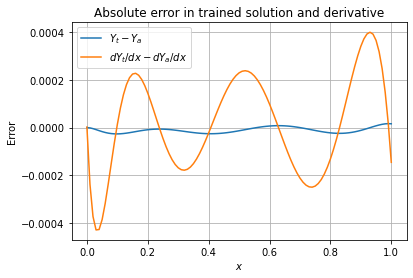

In [14]:
# Plot the errors in the trained solution and derivative.
Yt_err = Yt_test - Ya_test
dYt_dx_err = dYt_dx_test - dYa_dx_test
plt.plot(x_test, Yt_err, label = '$Y_t-Y_a$')
plt.plot(x_test, dYt_dx_err, label = '$dY_t/dx-dY_a/dx$')
plt.xlabel('$x$')
plt.ylabel('Error')
plt.grid()
plt.legend()
plt.title("Absolute error in trained solution and derivative");

### Examine training history

The history of the parameter values and the network loss function are available once training is complete. The loss function is simply the sum of the squared values of G for each training point:

\begin{equation}
    Loss = \sum_{i=1}^{n_t} G(x_i)^2
\end{equation}

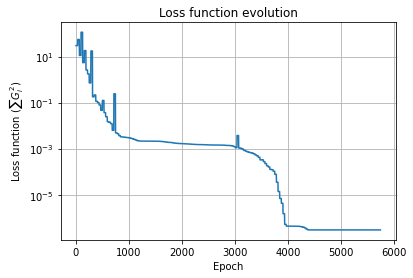

In [15]:
# Plot the loss function history.
plt.semilogy(net.losses)
plt.xlabel("Epoch")
plt.ylabel("Loss function ($\sum G_i^2$)")
plt.grid()
plt.title("Loss function evolution")
plt.show()

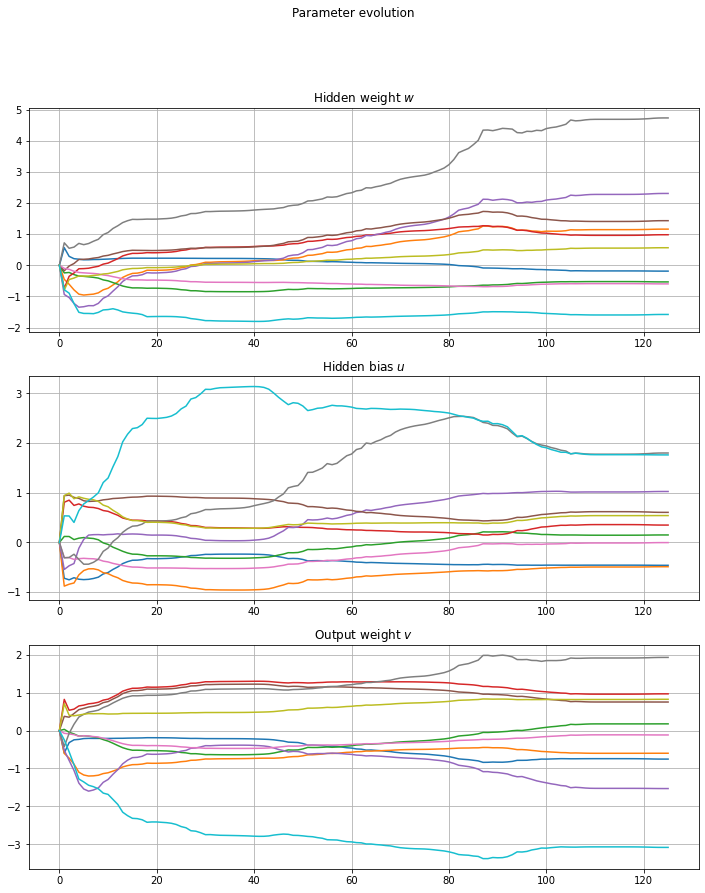

In [16]:
# Plot the parameter histories.
plt.figure(figsize=(12, 14))

# w
plt.subplot(311)
plt.plot(net.phist[:, 0:H])
plt.title("Hidden weight $w$")
plt.grid()

# u
plt.subplot(312)
plt.plot(net.phist[:, H:2*H])
plt.title("Hidden bias $u$")
plt.grid()

# v
plt.subplot(313)
plt.plot(net.phist[:, 2*H:3*H])
plt.title("Output weight $v$")
plt.grid()

plt.suptitle("Parameter evolution")
plt.subplots_adjust(hspace=0.2)
plt.show()